In [1]:
# library imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import glob

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
# load electrical demand data
df_load = pd.concat([pd.read_excel(filename, sheet_name="DUQ")[["DATE", "MAX"]]
                        for filename in sorted(glob.glob("*-hourly-loads.xls"))], 
                    ignore_index=True)

# load weather and get maximum by day
df_weather = pd.read_csv("kpit_weather.csv")
df_weather = df_weather[df_weather["Time"] != -9999]
df_weather["Date"] = df_weather["Time"].apply(lambda x: str(x)[:8])
df = df_weather.groupby("Date").max()[["OAT"]]
df["Temp"] = df["OAT"].apply(lambda x : x/10. * (9/5) + 32)

# join with load, then get just summer methods
df["Load"] = pd.Series(df_load["MAX"].values/1000, index=df.index)
df_summer = df[list(map(lambda x : x[4:6] in ["06", "07", "08"], df.index))].copy()

WARNING *** file size (6815616) not 512 + multiple of sector size (512)
WARNING *** file size (8757184) not 512 + multiple of sector size (512)


Text(0, 0.5, 'Peak Demand (GW)')

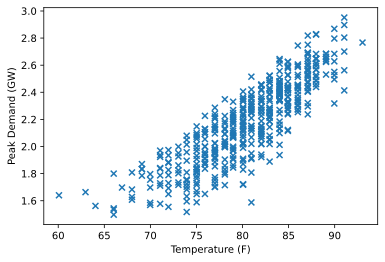

In [3]:
plt.scatter(df_summer["Temp"], df_summer["Load"], marker='x')
plt.xlabel("Temperature (F)")
plt.ylabel("Peak Demand (GW)")

We can normalize data in a number of ways, but a simple strategy is just to translate and scale the coordinates such that the values vary between zero and one in our dataset.  This can be easily achieved by the transformation
\begin{equation}
\tilde{x}^{(i)} = \frac{x^{(i)} - \min_i x^{(i)}}{\max_i x^{(i)} - \min_i x^{(i)}}
\end{equation}
and similarly for $\tilde{y}^{(i)}$.  

Text(0, 0.5, 'Normalized Demand')

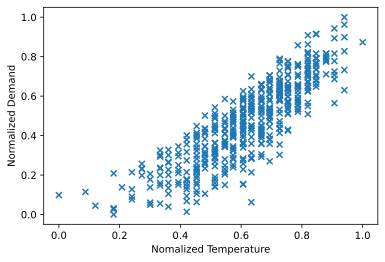

In [4]:
# Normalize data 
x = df_summer["Temp"].values
y = df_summer["Load"].values
x_nor = (x - min(x)) / (max(x) - min(x))
y_nor = (y - min(y)) / (max(y) - min(y))
plt.scatter(x_nor, y_nor, marker = 'x')
plt.xlabel("Nomalized Temperature")
plt.ylabel("Normalized Demand")

### The gradient descent algorithm (first pass)

The optimization function can be written as
\begin{equation}
E(\theta) = \frac{1}{m} \sum_{i=1}^m \left ( \theta_1 \cdot x^{(i)} + \theta_2 - y^{(i)} \right )^2.
\end{equation}
Compute the partial derivatives of this function with respect to $\theta_1$
\begin{equation}
\begin{split}
\frac{\partial E(\theta)}{\partial \theta_1} & = \frac{\partial}{\partial \theta_1} \frac{1}{m} \sum_{i=1}^m \left ( \theta_1 \cdot x^{(i)} + \theta_2 - y^{(i)} \right )^2 \\
& = \frac{1}{m} \sum_{i=1}^m \frac{\partial}{\partial \theta_1} \left ( \theta_1 \cdot x^{(i)} + \theta_2 - y^{(i)} \right )^2 \\
& = \frac{1}{m} \sum_{i=1}^m  2 \left ( \theta_1 \cdot x^{(i)} + \theta_2 - y^{(i)} \right ) \frac{\partial}{\partial \theta_1} \left (\theta_1 \cdot x^{(i)} + \theta_2 - y^{(i)} \right )  \\
& = \frac{1}{m} \sum_{i=1}^m  2 \left ( \theta_1 \cdot x^{(i)} + \theta_2 - y^{(i)} \right ) x^{(i)}
\end{split}
\end{equation}
Compute the partial derivative with respect to $\theta_2$
\begin{equation}
\begin{split}
\frac{\partial E(\theta)}{\partial \theta_2} & = \frac{\partial}{\partial \theta_2} \frac{1}{m} \sum_{i=1}^m \left ( \theta_1 \cdot x^{(i)} + \theta_2 - y^{(i)} \right )^2 \\
& = \frac{1}{m} \sum_{i=1}^m \frac{\partial}{\partial \theta_2} \left ( \theta_1 \cdot x^{(i)} + \theta_2 - y^{(i)} \right )^2 \\
& = \frac{1}{m} \sum_{i=1}^m  2 \left ( \theta_1 \cdot x^{(i)} + \theta_2 - y^{(i)} \right ) \frac{\partial}{\partial \theta_2} \left (\theta_1 \cdot x^{(i)} + \theta_2 - y^{(i)} \right )  \\
& = \frac{1}{m} \sum_{i=1}^m  2 \left ( \theta_1 \cdot x^{(i)} + \theta_2 - y^{(i)} \right )
\end{split}
\end{equation}
This leads to the gradient descent step where $\theta_1$ and $\theta_2$ are initialized to some value (usually simply zero), and updates are repeated
\begin{equation}
\begin{split}
\theta_1 & := \theta_1 - \frac{\alpha}{m} \sum_{i=1}^m  2 \left ( \theta_1 \cdot x^{(i)} + \theta_2 - y^{(i)} \right ) x^{(i)} \\
\theta_2 & := \theta_2 - \frac{\alpha}{m} \sum_{i=1}^m  2 \left ( \theta_1 \cdot x^{(i)} + \theta_2 - y^{(i)} \right ) \\
\end{split}
\end{equation}
where $\alpha$ is some small positive constant (indicating how big of a step in the direction of the negative gradient we take), called the _step size_.

In [5]:
def gradient_descent(iters):
    theta = np.array([0., 0.])
    alpha = 1.0
    for t in range(iters):
        theta[0] -= alpha/len(x) * 2 * sum((theta[0] * x_nor + theta[1] - y_nor)*x_nor)
        theta[1] -= alpha/len(x) * 2 * sum((theta[0] * x_nor + theta[1] - y_nor) )
    return theta

def plot_fit(theta):
    plt.scatter(x_nor, y_nor, marker = 'x')
    plt.xlabel("Nomalized Temperature")
    plt.ylabel("Normalized Demand")
    xlim, ylim =(plt.gca().get_xlim(), plt.gca().get_ylim())
    plt.plot(xlim, [theta[0]*xlim[0]+theta[1], theta[0]*xlim[1]+theta[1]], 'C1')
    plt.xlim(xlim)
    plt.ylim(ylim)

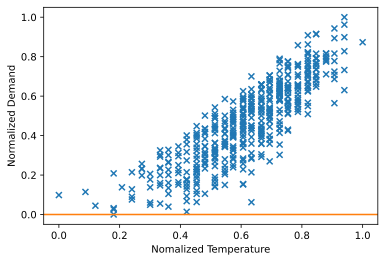

In [6]:
# The fit after 0 epochs (initialization)
plot_fit(gradient_descent(0))

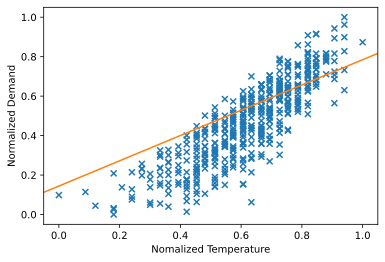

In [7]:
# The fit after 1 epoch
plot_fit(gradient_descent(1))

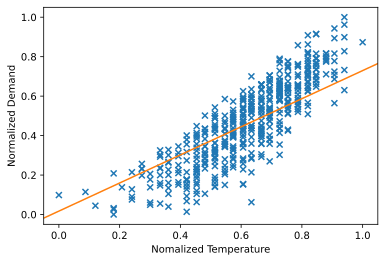

In [8]:
# The fit after 5 epochs
plot_fit(gradient_descent(5))

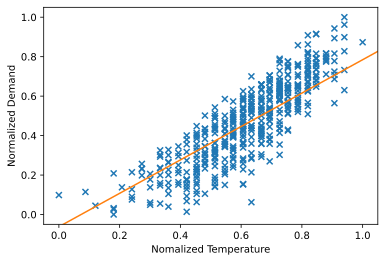

In [9]:
# The fit after 10 epochs
plot_fit(gradient_descent(10))

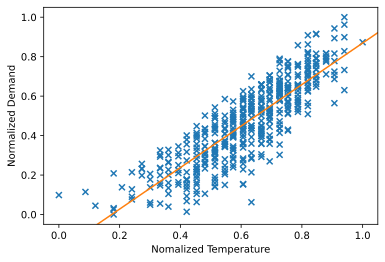

In [10]:
# The fit after 50 epochs
plot_fit(gradient_descent(50))

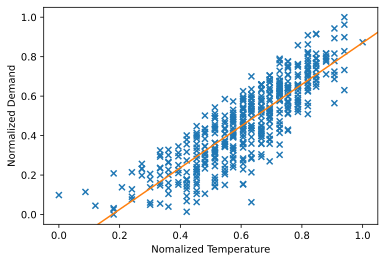

In [11]:
# The fit after 100 epochs
plot_fit(gradient_descent(100))

Text(0, 0.5, 'Average error')

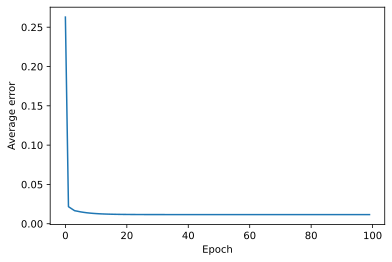

In [12]:
# Error vs. Epoch Graph
def gradient_descent_err(iters):
    err = []
    theta = np.array([0., 0.])
    alpha = 1.0
    for t in range(iters):
        err.append(np.mean((theta[0] * x_nor + theta[1] - y_nor)**2))
        theta[0] -= alpha/len(x) * 2 * sum((theta[0] * x_nor + theta[1] - y_nor)*x_nor)
        theta[1] -= alpha/len(x) * 2 * sum((theta[0] * x_nor + theta[1] - y_nor) )
    return np.array(err)

plt.plot(np.arange(0,100), gradient_descent_err(100))
plt.xlabel("Epoch")
plt.ylabel("Average error")

### Getting the answer back in the original coordinates

Since the model gives the approximation
\begin{equation}
\begin{split}
\tilde{y} & \approx \tilde{x} \cdot \theta_1 + \theta_2\\
\Longrightarrow \;\; \frac{y-a}{b} & \approx \frac{x-c}{d} \cdot \theta_1 + \theta_2 \\
\Longrightarrow \;\; y-a & \approx (x-c) \cdot(b \theta_1/d) + b \theta_2 \\
\Longrightarrow \;\; y & \approx x \cdot (b \theta_1/d) + b \theta_2 + a - c b \theta_1/d\\
\Longrightarrow \;\; y & \approx x \cdot \hat{\theta}_1 + \hat{\theta}_2\\
\end{split}
\end{equation}
where
\begin{equation}
a = \min_i y^{(i)}, \;\; b = \max_i y^{(i)} - \min_i y^{(i)}, \;\; c = \min_i x^{(i)}, \;\; d = \max_i x^{(i)} - \min_i x^{(i)}, 
\end{equation}
and 
\begin{equation}
\begin{split}
\hat{\theta}_1 & = b \theta_1/d \\
\hat{\theta}_2 & = b \theta_2 + a - c \cdot(b \theta_1/d).
\end{split}
\end{equation}

In [13]:
theta = gradient_descent(100)
a, b, c, d = min(y), max(y) - min(y), min(x), max(x) - min(x)
theta_hat = np.array([b * theta[0] / d, b*theta[1] + a - c*b*theta[0]/d])

Text(0, 0.5, 'Peak Demand (GW)')

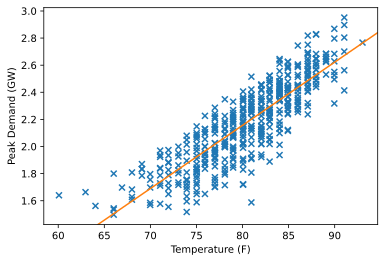

In [14]:
plt.scatter(df_summer["Temp"], df_summer["Load"], marker='x')
xlim, ylim =(plt.gca().get_xlim(), plt.gca().get_ylim())
plt.plot(xlim, [theta_hat[0]*xlim[0]+theta_hat[1], theta_hat[0]*xlim[1]+theta_hat[1]], 'C1')
plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel("Temperature (F)")
plt.ylabel("Peak Demand (GW)")

## Least squares revisited

What if one wanted to add additional features to our prediction instead of just the temperature?  
For example
\begin{equation}
x^{(i)} = \left [ \begin{array}{c} \mathrm{HighTemperature}^{(i)}\\ \mathrm{IsWeekday}^{(i)} \\ 1 \end{array} \right ]
\end{equation}
but the point is that we will always have a constant term 1 be the final feature.  The reason for doing so is that now we can use the simple linear hypothesis with $\theta \in \mathbb{R}^n$ and 
\begin{equation}
h_\theta(x) = \sum_{j=1}^n \theta_j x_j = \theta^T x.
\end{equation}

The key ingredients of the least square problem

1. Linear hypothesis function $h_\theta(x) = \sum_{j=1}^n \theta_j x_j$.
2. Squared error loss: $\ell(h_\theta(x), y) = (h_\theta(x) - y)^2$

These specify the first two elements of a machine learning algorithm
\begin{equation}
\minimize_\theta \;\; \frac{1}{m} \sum_{i=1}^m \left (\sum_{j=1}^n \theta_j x^{(i)}_j - y^{(i)} \right )^2
\end{equation}
where $E(\theta)$ is shorthand for this objective.

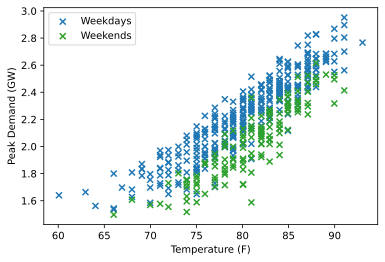

In [15]:
# add the weekday column to our data frame
import datetime
weekday = list(map(lambda x : datetime.datetime.strptime(x, "%Y%m%d").weekday() <= 4, df_summer.index))
df_summer.loc[:,"IsWeekday"] = weekday

plt.scatter(df_summer[df_summer["IsWeekday"]==True]["Temp"], 
            df_summer[df_summer["IsWeekday"]==True]["Load"], marker='x', color='C0')
plt.scatter(df_summer[df_summer["IsWeekday"]==False]["Temp"], 
            df_summer[df_summer["IsWeekday"]==False]["Load"], marker='x', color='C2')
plt.xlabel("Temperature (F)")
plt.ylabel("Peak Demand (GW)")
plt.legend(["Weekdays", "Weekends"])

### Analytic solution

Gradient descent is appealing in its generality but certainly also has some annoyances (picking step sizes, number of iterations, ensuring proper data normalization, etc).  These issues will be unavoidable for many of the problems we encounter, but it turns out that for least squares in particular, there is an alternative that is much easier to compute in many cases.  

For a function $f : \mathbb{R}^n \rightarrow \mathbb{R}$, the gradient, denoted $\nabla f(\theta)$, is a vector of all partial derivatives
\begin{equation}
\nabla f(\theta) \in \mathbb{R}^n = \left [ \begin{array}{c} 
\displaystyle \frac{\partial f(\theta)}{\partial \theta_1} \\
\displaystyle \frac{\partial f(\theta)}{\partial \theta_2} \\ \displaystyle \vdots \\
\displaystyle \frac{\partial f(\theta)}{\partial \theta_n} \end{array} \right ].
\end{equation}

First, write the gradient of the least squares objective more succinctly. 
\begin{equation}
\frac{\partial E(\theta)}{\partial \theta_j} = \frac{2}{m} \sum_{i=1}^m \left (\sum_{k=1}^n \theta_k x^{(i)}_k - y^{(i)} \right ) x^{(i)}_j
\end{equation}
Since the only term here that depends on $j$ is the final $x^{(i)}_j$, this immediately leads to the fact that
\begin{equation}
\nabla E(\theta) = \frac{2}{m} \sum_{i=1}^m x^{(i)} \left (\sum_{k=1}^n \theta_k x^{(i)}_k - y^{(i)} \right ).
\end{equation}

Use the fact that $\sum_{k=1}^n \theta_k x_k \equiv \theta^T x = x^T \theta$ to write this a bit more succintly as
\begin{equation}
\begin{split}
\nabla E(\theta) & = \frac{2}{m} \sum_{i=1}^m x^{(i)} \left ({x^{(i)}}^T \theta - y^{(i)} \right ) \\
& =\frac{2}{m} X^T (X \theta - y).
\end{split}
\end{equation}
Find the $\theta^\star$ that makes this entire term zero just with some linear algebra.
\begin{equation}
\nabla E(\theta^\star) = 0 \; \Longleftrightarrow \; \frac{2}{m} X^T (X \theta^\star - y) = 0 \; \Longleftrightarrow \theta^\star = (X^T X)^{-1} X^T y.
\end{equation}

In [16]:
# implementation of equation described above
def analytic_ls(X,y):
    theta = np.linalg.solve(X.T @ X, X.T @ y)
    return theta

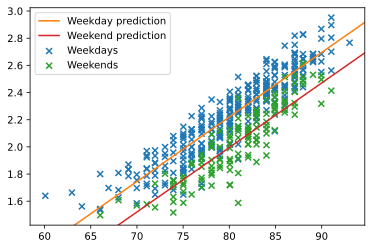

In [17]:
# fit of new data with cleaner implementation
X = np.array([df_summer["Temp"], df_summer["IsWeekday"].astype(float), np.ones(len(df_summer))]).T
y = df_summer["Load"].values.copy()
theta = analytic_ls(X,y)

plt.scatter(df_summer[df_summer["IsWeekday"]==True]["Temp"], 
            df_summer[df_summer["IsWeekday"]==True]["Load"], marker='x', color='C0')
plt.scatter(df_summer[df_summer["IsWeekday"]==False]["Temp"], 
            df_summer[df_summer["IsWeekday"]==False]["Load"], marker='x', color='C2')
xlim, ylim =(plt.gca().get_xlim(), plt.gca().get_ylim())
plt.plot(xlim, [theta[0]*xlim[0] + theta[1] + theta[2], theta[0]*xlim[1] + theta[1] + theta[2]], 'C1',
         xlim, [theta[0]*xlim[0] + theta[2], theta[0]*xlim[1] + theta[2]], 'C3')
plt.xlim(xlim)
plt.ylim(ylim)
plt.legend(["Weekday prediction", "Weekend prediction", "Weekdays", "Weekends"])